# Homework 3 Solutions

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance 
from sklearn import linear_model
import scipy.stats as stats
from statsmodels.regression.rolling import RollingOLS
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)

In [2]:
import os
os.getcwd()

'C:\\Users\\Olivi\\Desktop\\Uchi Code\\Risk\\HW3'

In [3]:
df = pd.read_excel('barnstable_analysis_data.xlsx', sheet_name = 1)

df = df.set_index('date')

df.head()

,SPX,TB1M
date,,
1926-01-30,-0.0018,0.0031
1926-02-27,-0.0333,0.0026
1926-03-31,-0.0577,0.0026
1926-04-30,0.0385,0.0023
1926-05-28,0.0136,0.0027


In [4]:
df.tail()

,SPX,TB1M
date,,
2022-04-29,-0.0876,0.0003
2022-05-31,0.0004,0.0006
2022-06-30,-0.0814,0.0009
2022-07-29,0.0937,0.0018
2022-08-31,-0.0402,0.0020


In [5]:
log_df = np.log(1 + df)

log_df.head()

,SPX,TB1M
date,,
1926-01-30,-0.0018,0.0031
1926-02-27,-0.0339,0.0026
1926-03-31,-0.0594,0.0026
1926-04-30,0.0378,0.0023
1926-05-28,0.0135,0.0027


# Modeling Volatility and VaR
## 1. Historic VaR.
### a. Plot

In [6]:
df[r'$\tilde{r}$'] = df['SPX'] - df['TB1M']
df.dropna(inplace = True)

df.head()

,SPX,TB1M,$\tilde{r}$
date,,,
1926-01-30,-0.0018,0.0031,-0.0048
1926-02-27,-0.0333,0.0026,-0.0359
1926-03-31,-0.0577,0.0026,-0.0603
1926-04-30,0.0385,0.0023,0.0363
1926-05-28,0.0136,0.0027,0.0109


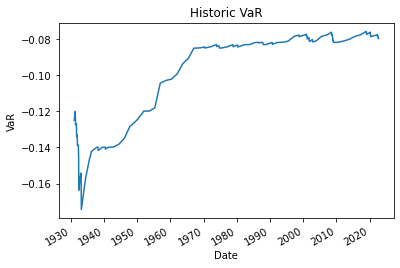

In [7]:
historic_VaR = df[r'$\tilde{r}$'].shift().expanding(min_periods = 60).quantile(.05)
historic_VaR.plot()

plt.title('Historic VaR')
plt.ylabel('VaR')
plt.xlabel('Date')
plt.show()

### b. Frequency of periods

In [8]:
round(len(df[r'$\tilde{r}$'][df[r'$\tilde{r}$'] < historic_VaR]) / len(historic_VaR.dropna()), 4)

0.0303

### c. Drawback
By definition of VaR, number instances of return be less than 5%-VaR should be close to 5%, but in our case it is less than 3%


This method of calculation is valid if there is a **smooth tail**, and does not give correct result if tails are not smooth.

It shows the problem of historical VaR: Give past data equal weight regardless of how old they are. (New/Present data should have more weight.)

## 2. Volatility
Expanding and Rolling Windows:

In [9]:
stdev = np.sqrt((df[r'$\tilde{r}$']**2).shift(1).expanding(60).mean().to_frame('Expanding Window'))

stdev['Rolling Window'] = np.sqrt((df[r'$\tilde{r}$']**2).shift(1).rolling(60).mean())

In [10]:
stdev.head()

,Expanding Window,Rolling Window
date,,
1926-01-30,NaN,NaN
1926-02-27,NaN,NaN
1926-03-31,NaN,NaN
1926-04-30,NaN,NaN
1926-05-28,NaN,NaN


### a. Plot Sigma

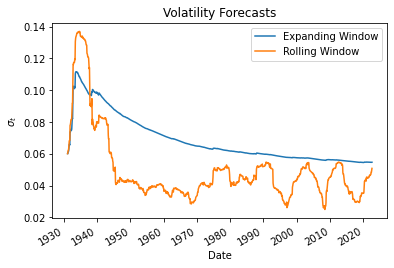

In [11]:
### Initialize with the given parameter
stdev.iloc[0,2:] = 0.15

### Simulate the rest of the period using the initial stdev given
    ### Forecast variance by plugging the GARCH and IGARCH parameters into their respective equations   
stdev.dropna(inplace = True)

stdev.plot()

plt.title('Volatility Forecasts')
plt.ylabel(r'$\sigma_{t}$')
plt.xlabel('Date')
plt.show()

### b. 5th percentile 1-month-ahead VaR

In [12]:
VaR = -1.65 * stdev
VaR.head()

,Expanding Window,Rolling Window
date,,
1931-01-31,-0.0992,-0.0992
1931-02-28,-0.0992,-0.1000
1931-03-31,-0.1010,-0.1024
1931-04-30,-0.1013,-0.1027
1931-05-29,-0.1023,-0.1043


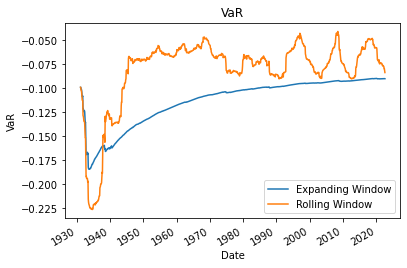

In [13]:
VaR.plot()
plt.title('VaR')
plt.ylabel('VaR')
plt.xlabel('Date')
plt.show()

### c. Frequency

In [14]:
freq_df = pd.DataFrame(index = ['Frequency'], columns = VaR.columns)

for col in freq_df:
    freq_df[col] = len(VaR[df.loc[VaR.index, r'$\tilde{r}$'] < VaR[col]]) / len(VaR[col].dropna().index)
    
round(freq_df, 4)

,Expanding Window,Rolling Window
Frequency,0.0175,0.0496


In [15]:
VaR.head()

,Expanding Window,Rolling Window
date,,
1931-01-31,-0.0992,-0.0992
1931-02-28,-0.0992,-0.1000
1931-03-31,-0.1010,-0.1024
1931-04-30,-0.1013,-0.1027
1931-05-29,-0.1023,-0.1043


### d. Compare

## 3. CVaR
### Historical Window

In [16]:
historical_CVaR = pd.Series(index = historic_VaR.index)
for i in historical_CVaR.index:
    r = df[r'$\tilde{r}$'].shift().loc[:i]
    historical_CVaR.loc[i] = r[r < historic_VaR.loc[i]].mean()
historical_CVaR.head()

date
1926-01-30   NaN
1926-02-27   NaN
1926-03-31   NaN
1926-04-30   NaN
1926-05-28   NaN
dtype: float64

In [17]:
# Another way (similar) provided by TA in the discussion
# The result is the same
historic_CVaR = []
return_data = df[r'$\tilde{r}$']
for i in range(len(return_data)):
    if i < 61:
        historic_CVaR.append(np.nan)
    else:
        window = return_data[:i-1]
        CVaR = window[window < window.quantile(0.05)].mean()
        historic_CVaR.append(CVaR)

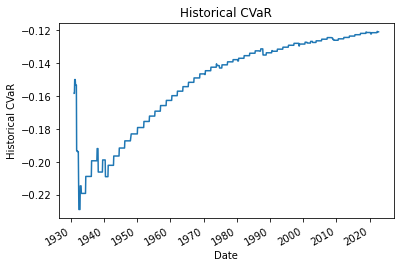

In [18]:
historical_CVaR.plot()
plt.title('Historical CVaR')
plt.ylabel('Historical CVaR')
plt.xlabel('Date')
plt.show()

### Expanding Window

In [19]:
CVaR = -1.65 * stdev / 0.05
CVaR.head()

,Expanding Window,Rolling Window
date,,
1931-01-31,-1.9844,-1.9844
1931-02-28,-1.9835,-1.9998
1931-03-31,-2.0204,-2.0480
1931-04-30,-2.0251,-2.0534
1931-05-29,-2.0460,-2.0861


In [20]:
expanding_CVaR = pd.Series(index = VaR.index[60:])
for i in expanding_CVaR.index:
    r = df[r'$\tilde{r}$'].shift().loc[:i]
    expanding_CVaR.loc[i] = r[r < VaR.loc[i,'Expanding Window']].mean()
expanding_CVaR.head()

date
1936-02-29   -0.2192
1936-03-31   -0.2192
1936-04-30   -0.2192
1936-05-29   -0.2192
1936-06-30   -0.2192
dtype: float64

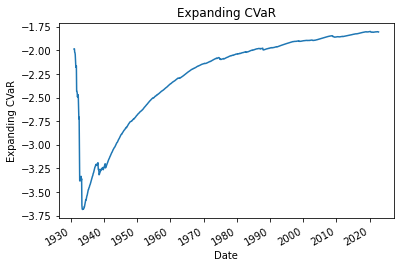

In [21]:
# expanding_CVaR.plot()
CVaR['Expanding Window'].plot()
plt.title('Expanding CVaR')
plt.ylabel('Expanding CVaR')
plt.xlabel('Date')
plt.show()

### Rolling Window

In [22]:
rolling_CVaR = pd.Series(index = VaR.index[60:])
for i in rolling_CVaR.index:
    r = df[r'$\tilde{r}$'].shift().loc[:i]
    rolling_CVaR.loc[i] = r[r < VaR.loc[i,'Rolling Window']].mean()
rolling_CVaR.head()

date
1936-02-29   -0.2603
1936-03-31   -0.2603
1936-04-30   -0.2603
1936-05-29   -0.2603
1936-06-30   -0.2603
dtype: float64

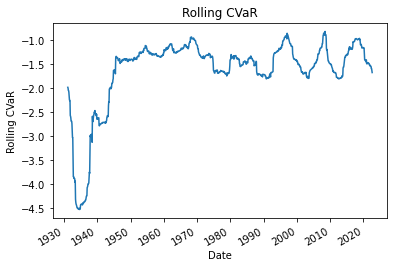

In [23]:
# rolling_CVaR.plot()
CVaR['Rolling Window'].plot()
plt.title('Rolling CVaR')
plt.ylabel('Rolling CVaR')
plt.xlabel('Date')
plt.show()

## 4. Extra
EWMA:

In [24]:
IGARCH = arch_model(df[r'$\tilde{r}$'])

theta = 0.97

IGARCH.volatility = EWMAVariance(theta)

IGARCH_model = IGARCH.fit()

IGARCH_model.params

Iteration:      1,   Func. Count:      3,   Neg. LLF: 3984570.5364937778
Iteration:      2,   Func. Count:     10,   Neg. LLF: -1858.8039187809004
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1858.8039187817976
            Iterations: 2
            Function evaluations: 10
            Gradient evaluations: 2


mu    0.007
Name: params, dtype: float64

GARCH:

In [25]:
GARCH = arch_model(df[r'$\tilde{r}$'], vol='Garch', p=1, o=0, q=1, dist='Normal')

GARCH_model = GARCH.fit()

GARCH_model.params

Iteration:      1,   Func. Count:      6,   Neg. LLF: 38084950.95951727
Iteration:      2,   Func. Count:     16,   Neg. LLF: -1909.9199599735189
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1909.9199630529993
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2


mu          7.8426e-03
omega       5.8962e-05
alpha[1]    1.0000e-01
beta[1]     8.8000e-01
Name: params, dtype: float64

# 3. Underperformance
## 1. Summary
The earlier subsample has much higher mean returns, but similar excess returns due to the notable decrease in risk free rate.

The log returns show lower mean returns as expected.

In [26]:
def annualized_stats(data, annual_factor, log = False):
    if log == False:
        df = pd.DataFrame(data = None, 
                          index = [r'$r^{M}$',r'${\tilde{r}^{M}}$',r'$r^{f}$'])
    else: 
        df = pd.DataFrame(data = None, 
                      index = [r'log$r^{M}$',r'log${\tilde{r}^{M}}$',r'log$r^{f}$'])
        
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + r' $\mu$'] = [data['SPX'].mean(),
                                                                                data['SPX'].mean()-data['TB1M'].mean(),
                                                                                data['TB1M'].mean()] 
    
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + r' $\mu$'] *= annual_factor
    
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + r' $\sigma$'] = [data['SPX'].std(),
                                                                                   (data['SPX']-data['TB1M']).std(),
                                                                                   data['TB1M'].std()] 
    
    df[str(data.index[0].year) + '-' + str(data.index[-1].year) + r' $\sigma$'] *= np.sqrt(annual_factor)
    
    return df

In [27]:
def join(df_list):
    df = df_list[0]
    
    for df_ in df_list[1:]:
        df = df.join(df_)
    
    return df

In [28]:
stats_ = join([annualized_stats(df.loc['1965':'1999'], 12),
             annualized_stats(df.loc['2000':], 12),
             annualized_stats(df.loc['1926':], 12)])

log_stats = join([annualized_stats(log_df.loc['1965':'1999'], 12, log = True),
                 annualized_stats(log_df.loc['2000':], 12, log = True),
                 annualized_stats(log_df.loc['1926':], 12, log = True)])

stats_df = stats_.append(log_stats)
stats_df

,1965-1999 $\mu$,1965-1999 $\sigma$,2000-2022 $\mu$,2000-2022 $\sigma$,1926-2022 $\mu$,1926-2022 $\sigma$
$r^{M}$,0.1302,0.1495,0.0759,0.1526,0.1132,0.1878
${\tilde{r}^{M}}$,0.0687,0.1502,0.0616,0.1531,0.0816,0.1881
$r^{f}$,0.0615,0.0072,0.0143,0.0050,0.0315,0.0086
log$r^{M}$,0.1176,0.1496,0.0640,0.1537,0.0957,0.1867
log${\tilde{r}^{M}}$,0.0563,0.1504,0.0497,0.1542,0.0642,0.1873
log$r^{f}$,0.0613,0.0071,0.0143,0.0050,0.0315,0.0085


## 2. Prob(Market underperform risk-free)

In [29]:
def prob_calc(h, tilde_mu, tilde_sigma):
    return stats.norm.cdf(- np.sqrt(h) * tilde_mu / tilde_sigma)

def prob(h, tilde_mu, tilde_sigma):
    prob_df = pd.DataFrame(data = h, columns = ['h'])
    
    prob_df['Probability'] = prob_calc(prob_df['h'], tilde_mu, tilde_sigma)
    
    prob_df = prob_df.set_index('h')
    
    return prob_df

In [30]:
stats_df

,1965-1999 $\mu$,1965-1999 $\sigma$,2000-2022 $\mu$,2000-2022 $\sigma$,1926-2022 $\mu$,1926-2022 $\sigma$
$r^{M}$,0.1302,0.1495,0.0759,0.1526,0.1132,0.1878
${\tilde{r}^{M}}$,0.0687,0.1502,0.0616,0.1531,0.0816,0.1881
$r^{f}$,0.0615,0.0072,0.0143,0.0050,0.0315,0.0086
log$r^{M}$,0.1176,0.1496,0.0640,0.1537,0.0957,0.1867
log${\tilde{r}^{M}}$,0.0563,0.1504,0.0497,0.1542,0.0642,0.1873
log$r^{f}$,0.0613,0.0071,0.0143,0.0050,0.0315,0.0085


### (a)

In [31]:
mu_tilde = stats_df.iloc[4, 0]
sigma_tilde = stats_df.iloc[4, 1]
h = 2021 - 1999

prob([h], mu_tilde, sigma_tilde)

,Probability
h,
22,0.0396


### (b) Precise probability for h = 15 and h = 30 years are shown below.

In [32]:
prob([15, 30], mu_tilde, sigma_tilde)

,Probability
h,
15,0.0736
30,0.0202


### (c)

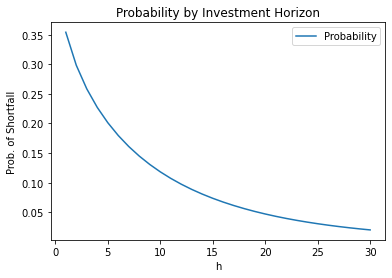

In [33]:
prob_horizon = prob(list(range(1, 31)), mu_tilde, sigma_tilde)

prob_horizon.plot() 
plt.title('Probability by Investment Horizon')
plt.ylabel('Prob. of Shortfall')
plt.show()

## 3. Calculating Probabilities 1965-2022

In [34]:
log_df1965 = log_df.loc['1965':].dropna()
mu_tilde = (log_df1965['SPX'].mean()-log_df1965['TB1M'].mean()) * 12
sigma_tilde = (log_df1965['SPX']-log_df1965['TB1M']).std() * np.sqrt(12)

prob(list(range(5,35, 5)), mu_tilde, sigma_tilde)

,Probability
h,
5,0.2124
10,0.1295
15,0.0834
20,0.0552
25,0.0372
30,0.0253


## 4. Barnstable's Expectations
Barnstable theory assumes that **log returns are normally distributed and i.i.d.**, thus the mean of our portfolio will be proportional to the holding period, while the standard deviation of the portfolio will be proportional to the square root of the holding period, making the probability of beating the benchmark higher and higher with the increase of the holding period.

In [35]:
mu = stats_df.iloc[3,0]
bar_r = stats_df.iloc[3,2]
sigma = stats_df.iloc[3,1]

prob([23], mu - bar_r, sigma)

,Probability
h,
23,0.0429


In [36]:
strike = np.log(1.06)

mu65 = log_df1965['SPX'].mean() * 12

sigma65 = log_df1965['SPX'].std() * np.sqrt(12)

mu = 23/7 * (stats_df.iloc[3, 2] - strike) + mu65 - strike

prob([7], mu, sigma65)

,Probability
h,
7,0.1567
